In [60]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from matplotlib import pyplot as plt
import seaborn as sns

import tensorflow as tf
import os

In [62]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Data preparation

In [65]:
base_dir = "C:/Users/taona/Documents/my work/Breast Cancer Histopathology Image Classification/data/raw/archive/"
csv_path = "Folds.csv"

fold = 1
target_size = (244,244)
batch_size = 32

In [67]:
df = pd.read_csv(base_dir + csv_path)

df.head()

,fold,mag,grp,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...


In [69]:
train_df = df[(df['fold'] == fold) & (df['grp'] == 'train')].copy()
test_df  = df[(df['fold'] == fold) & (df['grp'] == 'test')].copy()


In [71]:
train_df['label'] = train_df['filename'].apply(lambda x: 'benign' if 'benign' in x.lower() else 'malignant')
test_df['label']  = test_df['filename'].apply(lambda x: 'benign' if 'benign' in x.lower() else 'malignant')

In [73]:
train_df['filepath'] = train_df['filename'].apply(lambda x: os.path.join(base_dir, x))
test_df['filepath']  = test_df['filename'].apply(lambda x: os.path.join(base_dir, x))


In [75]:
train_df["filepath"][0]

'C:/Users/taona/Documents/my work/Breast Cancer Histopathology Image Classification/data/raw/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-001.png'

# Creating data generators


In [78]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Increased rotation
    width_shift_range=0.2,  # Increased shift
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,  # Added vertical flip
    fill_mode='nearest'
)

In [80]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [82]:
train_gen = datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='filepath',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary'
    )

Found 5005 validated image filenames belonging to 2 classes.


In [84]:
test_gen = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='filepath',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )

Found 2904 validated image filenames belonging to 2 classes.


# Deep Model

### Building the Deep learning model

In [89]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [91]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(244, 244, 3)
)

base_model.trainable = False

model = Sequential([
    Input(shape=(244, 244, 3)),
    base_model,
    
    Conv2D(16, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.2),
    
    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.3),
    
    Conv2D(16, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.3),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 215s 2us/step


In [93]:
initial_learning_rate = 0.001
decay_steps = 1000
decay_rate = 0.9

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss=tf.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [95]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 16)       │       294,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 4, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 2, 2, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 2, 2, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 1, 1, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1, 1, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,896,769 (91.16 MB)

 Trainable params: 308,929 (1.18 MB)

 Non-trainable params: 23,587,840 (89.98 MB)

### Training

In [97]:
logdir = 'logs'

In [99]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [114]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

hist = model.fit(
    train_gen,
    epochs=20,  
    steps_per_epoch=len(train_gen),
    validation_data=test_gen,
    validation_steps=len(test_gen),
    callbacks=[tensorboard_callback, early_stopping]
)

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 386s 2s/step - accuracy: 0.7086 - loss: 0.5934 - val_accuracy: 0.6543 - val_loss: 0.6554
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 393s 3s/step - accuracy: 0.7072 - loss: 0.5988 - val_accuracy: 0.4366 - val_loss: 0.7118
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 412s 3s/step - accuracy: 0.7024 - loss: 0.6028 - val_accuracy: 0.4776 - val_loss: 0.7005
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 419s 3s/step - accuracy: 0.7169 - loss: 0.5925 - val_accuracy: 0.6529 - val_loss: 0.6605
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 454s 3s/step - accuracy: 0.6962 - loss: 0.6082 - val_accuracy: 0.6529 - val_loss: 0.6561
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 441s 3s/step - accuracy: 0.6979 - loss: 0.6024 - val_accuracy: 0.6529 - val_loss: 0.6487
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 433s 3s/step - accuracy: 0.7104 - loss: 0.5911 - val_accuracy: 0.6670 - val_loss: 0.6619
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 426s 3s/step - accuracy: 0.6941 - loss: 0.6050 - val_accu

### Loss Line Graph

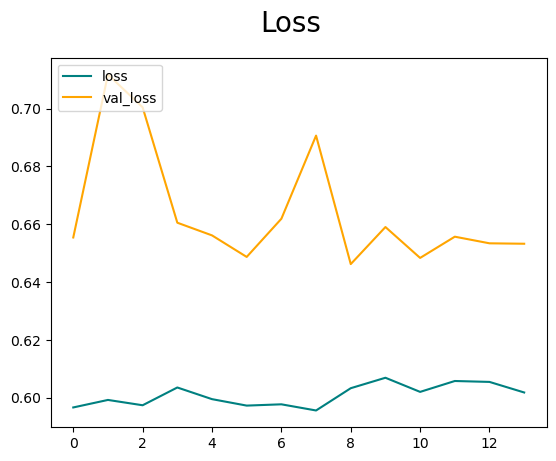

In [116]:
fig = plt.figure()
plt.plot(hist.history['loss'], color="teal", label='loss')
plt.plot(hist.history['val_loss'], color="orange", label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### Accuracy Line Graph

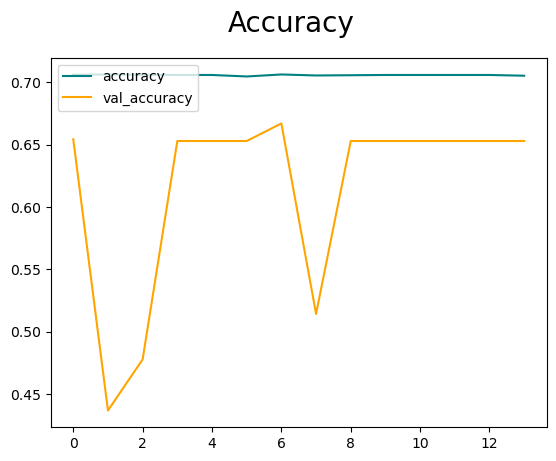

In [118]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color="teal", label='accuracy')
plt.plot(hist.history['val_accuracy'], color="orange", label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Evaluating Perfomance

### Evaluation

In [218]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [222]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [226]:
print(len(test_gen))

91


In [ ]:
for batch in test_df.as_numpy_iterator():
     x, y = batch
     yhat = model.predict(x)
     pre.update_state(y, yhat)
     re.update_state(y, yhat)
     acc.update_state(y, yhat)

AttributeError: 'DataFrame' object has no attribute 'as_numpy_iterator'

In [45]:
x, y = next(test_gen)
yhat = model.predict(x)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


In [47]:
print(f"Precision: {pre.result().numpy()}, Recall: {re.result(),numpy()}, Accuracy: {acc.result().numpy()}")

NameError: name 'pre' is not defined

### confusion matrix


# Testing the model

In [2]:
import cv2

ModuleNotFoundError: No module named 'cv2'

In [3]:
img = cv2.imread("my_image_here")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

NameError: name 'plt' is not defined

In [211]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(reize.numpy().astype(int))
plt.show()

NameError: name 'img' is not defined

In [ ]:
yhat = model.predict(np.expand_dims(resize/255,0))

In [ ]:
yhat


In [ ]:
if yhat > 0.5:
    print("Predicted class is benign")
else:
    print("Predicted class is malignant")

# Saving the model

In [242]:
from tensorflow.keras.models import load_model

In [246]:
model.save(os.path.join('models', 'Breast_Cancer_Histopathology_Image_Classification_model.keras'))

In [250]:
new_model = load_model(os.path.join('models', 'Breast_Cancer_Histopathology_Image_Classification_model.keras'))

C:\Users\taona\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))

In [ ]:
if yhatnew > 0.5:
    print("Predicted class is benign")
else:
    print("Predicted class is malignant")